In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras import datasets, layers, models
from tensorflow.math import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import cv2
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/스마트해상물류_공유/ships-dataset/game/train/train.csv")

<Axes: xlabel='category', ylabel='count'>

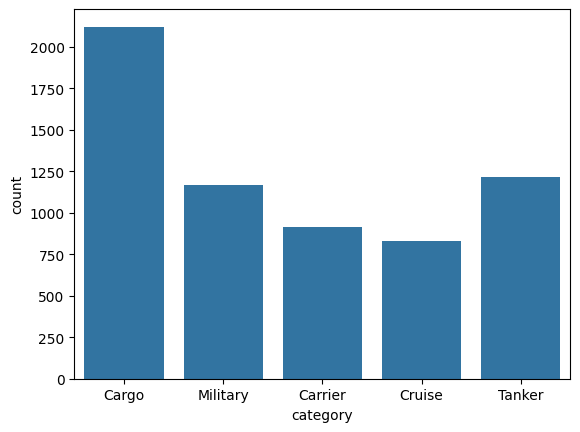

In [ ]:
ship_categories = {1: 'Cargo', 2: 'Military', 3: 'Carrier', 4: 'Cruise', 5: 'Tanker'}
sns.countplot(x=train["category"].map(ship_categories))

In [ ]:
path = "/content/drive/MyDrive/스마트해상물류_공유/ships-dataset/game/train/images"
target_shape = (128, 128, 3)

def load_and_preprocess_image(image_path, target_shape):
    img = plt.imread(image_path)
    img = cv2.resize(img, (target_shape[1], target_shape[0]))  # Resize the image
    return img

In [ ]:
# 바로 아래 셀 실행 필요 없음. resized_image_list 불러오면 됨.

In [ ]:
from tqdm import tqdm

refactor_size = 128
resized_image_list = []
all_paths = []

for i in tqdm(range(len(train))):
    image_path = os.path.join(path, train["image"][i])
    img = tf.keras.utils.load_img(image_path, target_size=(refactor_size, refactor_size))
    img_vals = tf.image.convert_image_dtype(img, tf.float32)
    imgarr = tf.keras.utils.img_to_array(img_vals)
    resized_image_list.append(imgarr)
    all_paths.append(image_path)

resized_image_list = np.asarray(resized_image_list)

100%|██████████| 6252/6252 [10:37<00:00,  9.80it/s]


In [ ]:
import numpy as np

# NumPy 파일로 저장
# np.save('/content/drive/MyDrive/스마트해상물류_공유/ships-dataset/game/resized_image_list.npy', resized_image_list)

# 나중에 불러오기
resized_image_list = np.load('/content/drive/MyDrive/스마트해상물류_공유/ships-dataset/game/resized_image_list.npy')

## Plotting first 20 Images

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])
augmented_images = data_augmentation(resized_image_list)

In [ ]:
class_values = train["category"] - 1
class_values.value_counts()

,count
category,
0,2120
4,1217
1,1167
2,916
3,832


In [ ]:
ship_categories = {0: 'Cargo', 1: 'Military', 2: 'Carrier', 3: 'Cruise', 4: 'Tanker'}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(resized_image_list, class_values,random_state=30)
print(X_train.shape, y_train.shape)

(4689, 128, 128, 3) (4689,)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_model():
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ])

    model = models.Sequential([
        tf.keras.Input(shape=(128, 128, 3)),
        data_augmentation,

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

     
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

    
        layers.Dense(5, activation='softmax')
    ])

    return model


model = create_cnn_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [ ]:
# ModelCheckpoint 설정
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [ ]:
import tensorflow as tf
from tensorflow import keras

# best_model = keras.models.load_model('/content/drive/MyDrive/스마트해상물류_공유/ships-dataset/game/train/hj3_model.keras', compile=False)
# # # best_model = keras.models.load_model('/content/drive/MyDrive/스마트해상물류_공유/ships-dataset/game/train/staged_adversarial_model.keras', compile=False)
model.load_weights('/content/drive/MyDrive/스마트해상물류_공유/ships-dataset/game/train/hj_model.keras')
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
test_loss, best_test_acc = model.evaluate(X_test, y_test, verbose=2)
print("\nBest Test Accuracy:", best_test_acc)

49/49 - 4s - 78ms/step - accuracy: 0.8426 - loss: 0.4822

Best Test Accuracy: 0.8426103591918945


In [ ]:
def fgsm_attack(image, epsilon, gradient):
    sign_gradient = tf.sign(gradient)
    perturbed_image = image + epsilon * sign_gradient
    perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)
    return perturbed_image

# 손실 함수 정의 - SparseCategoricalCrossentropy 사용 (if y_test is not one-hot encoded)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

# FGSM 공격을 적용한 데이터셋 평가
def evaluate_with_fgsm(model, X_test, y_test, epsilon=0.01):
    perturbed_images = []

    for i in range(len(X_test)):
        image = tf.convert_to_tensor(X_test[i:i+1])
        label = tf.convert_to_tensor(y_test[i:i+1])

        with tf.GradientTape() as tape:
            tape.watch(image)
            prediction = model(image)
            loss = loss_object(label, prediction)

        gradient = tape.gradient(loss, image)
        perturbed_image = fgsm_attack(image, epsilon, gradient)
        perturbed_images.append(perturbed_image.numpy())

    perturbed_images = np.vstack(perturbed_images)

    # FGSM 공격을 받은 이미지로 모델 재평가
    perturbed_loss, perturbed_acc = model.evaluate(perturbed_images, y_test, verbose=2)
    print(f"Perturbed Test Loss: {perturbed_loss:.4f}")
    print(f"Perturbed Test Accuracy: {perturbed_acc:.4f}")

    return perturbed_images

# FGSM 공격 후 손상된 이미지 생성
perturbed_images = evaluate_with_fgsm(model, X_test, y_test, epsilon=0.1)

49/49 - 3s - 52ms/step - accuracy: 0.1862 - loss: 6.2741
Perturbed Test Loss: 6.2741
Perturbed Test Accuracy: 0.1862


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models


# 적대적 학습 함수
def adversarial_training(model, X_train, y_train, perturbed_train, epochs=10, batch_size=32):
    optimizer = tf.keras.optimizers.Adam()
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for i in range(0, len(X_train), batch_size):
            images = X_train[i:i+batch_size]
            labels = y_train[i:i+batch_size]
            adv_images = perturbed_train[i:i+batch_size]  # 적대적 이미지

            # 원본 이미지로 학습
            with tf.GradientTape() as tape:
                predictions = model(images)
                loss = loss_object(labels, predictions)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # 적대적 이미지로 학습
            with tf.GradientTape() as tape:
                predictions_adv = model(adv_images)
                loss_adv = loss_object(labels, predictions_adv)
            gradients_adv = tape.gradient(loss_adv, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients_adv, model.trainable_variables))

        print(f"Loss: {loss.numpy()}, Adversarial Loss: {loss_adv.numpy()}")

# 모델 평가 함수 정의
def evaluate_model(model, X_test, y_test, perturbed_test):

    # 적대적 테스트셋 평가
    print("Evaluating on adversarial test set:")
    loss_adv, acc_adv = model.evaluate(perturbed_test, y_test, verbose=2)
    print(f"Adversarial Test Loss: {loss_adv:.4f}, Adversarial Test Accuracy: {acc_adv:.4f}")

# 전체 훈련 및 추론 흐름
def main():

    # 손상된 훈련셋과 테스트셋을 npy 파일에서 로드
    perturbed_train = np.load('/content/drive/MyDrive/스마트해상물류_공유/ships-dataset/game/fgsm_perturbed_images/perturbed_train.npy')  # FGSM 공격으로 손상된 훈련셋
    perturbed_test = np.load('/content/drive/MyDrive/스마트해상물류_공유/ships-dataset/game/fgsm_perturbed_images/perturbed_test.npy')    # FGSM 공격으로 손상된 테스트셋

    # CNN 모델 생성 및 컴파일
    model = create_cnn_model()
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # 적대적 학습 수행 (원본 + 손상된 훈련 데이터셋 사용)
    adversarial_training(model, X_train, y_train, perturbed_train, epochs=10, batch_size=32)

    # 모델 평가 (원본 및 적대적 테스트셋)
    evaluate_model(model, X_test, y_test, perturbed_test)

# 실행
if __name__ == "__main__":
    main()


Training data shape: (4689, 128, 128, 3), Labels shape: (4689,)
Epoch 1/10
Loss: 1.259907841682434, Adversarial Loss: 1.3169010877609253
Epoch 2/10
Loss: 1.182040810585022, Adversarial Loss: 1.1552435159683228
Epoch 3/10
Loss: 1.2259204387664795, Adversarial Loss: 0.8993434906005859
Epoch 4/10
Loss: 0.7013557553291321, Adversarial Loss: 0.893486499786377
Epoch 5/10
Loss: 0.7296855449676514, Adversarial Loss: 0.7733339667320251
Epoch 6/10
Loss: 0.651315450668335, Adversarial Loss: 0.432669073343277
Epoch 7/10
Loss: 0.6079698204994202, Adversarial Loss: 0.26447001099586487
Epoch 8/10
Loss: 0.5085634589195251, Adversarial Loss: 0.324272096157074
Epoch 9/10
Loss: 0.4608844816684723, Adversarial Loss: 0.19483396410942078
Epoch 10/10
Loss: 0.6479285955429077, Adversarial Loss: 0.21058113873004913
Evaluating on original test set:
49/49 - 2s - 42ms/step - accuracy: 0.6679 - loss: 1.0481
Original Test Loss: 1.0481, Test Accuracy: 0.6679
Evaluating on adversarial test set:
49/49 - 1s - 20ms/step